In [1]:
using MLJ
using Plots 
import DataFrames: DataFrame 
using StableRNGs

# Learning Networks

first let's generate some dummy data

In [2]:
rng = StableRNG(42) # for reproducibility

StableRNGs.LehmerRNG(state=0x00000000000000000000000000000055)

In [3]:
Ridge = @load RidgeRegressor pkg=MultivariateStats

import MLJMultivariateStatsInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/john/.julia/packages/MLJModels/GKDnU/src/loading.jl:168


MLJMultivariateStatsInterface.RidgeRegressor

In [4]:
x1 = rand(rng, 300)
x2 = rand(rng, 300)
x3 = rand(rng, 300)
y = exp.(x1 - x2 -2x3 + 0.1*rand(rng, 300))

X = DataFrame(x1=x1, x2=x2, x3=x3)
first(X, 3) |> pretty

┌────────────┬────────────┬────────────┐
│ x1         │ x2         │ x3         │
│ Float64    │ Float64    │ Float64    │
│ Continuous │ Continuous │ Continuous │
├────────────┼────────────┼────────────┤
│ 0.580515   │ 0.942777   │ 0.100383   │
│ 0.191241   │ 0.427903   │ 0.154318   │
│ 0.971133   │ 0.951418   │ 0.528234   │
└────────────┴────────────┴────────────┘


Further, let's prepare the train/test split

In [5]:
train, test = partition(eachindex(y), 0.8);
println(size(train))
println(size(test))

(240,)
(60,)


A *learning network* is a directed acyclic graph (DAG) whose *nodes* applying operations like `predict`, `transform`, `+`, `vcat`, etc... 

Consider the following: 

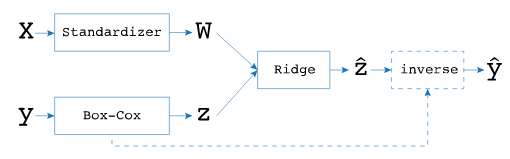

## sources and nodes

Learning networks start a *source* nodes and flow forward through the DAG

In [6]:
Xs = source(X)
ys = source(y)

Source @047 ⏎ `AbstractVector{Continuous}`

we define a *trained* node by creating a machine that wraps a model around another node. 

In [7]:
stand = machine(Standardizer(), Xs) 
W = transform(stand, Xs)  # the new node

Node{Machine{Standardizer,…}}
  args:
    1:	Source @777
  formula:
    transform(
        Machine{Standardizer,…}, 
        Source @777)

we can `fit!` a trained-opertaion node at any point. MLJ will fit whatever it needs upstream 

In [8]:
fit!(W, rows=train)

┌ Info: Training Machine{Standardizer,…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:403


Node{Machine{Standardizer,…}}
  args:
    1:	Source @777
  formula:
    transform(
        Machine{Standardizer,…}, 
        Source @777)

In [9]:
W() # transforms all data
W(rows=test,) # transforms only test data 
W(X[3:4, :]) # transform specific data

,x1,x2,x3
,Float64,Float64,Float64
1,1.53119,1.55219,0.0148474
2,0.744268,1.44683,-1.23438


Let's define the rest of the nodes in the model graph

In [10]:
box_model = UnivariateBoxCoxTransformer()
box = machine(box_model, ys) 
z = transform(box, ys)

Node{Machine{UnivariateBoxCoxTransformer,…}}
  args:
    1:	Source @047
  formula:
    transform(
        Machine{UnivariateBoxCoxTransformer,…}, 
        Source @047)

In [11]:
ridge_model = Ridge(lambda=0.1) 
ridge = machine(ridge_model, W, z) 
ẑ = predict(ridge, W) 

ŷ = inverse_transform(box, ẑ)

Node{Machine{UnivariateBoxCoxTransformer,…}}
  args:
    1:	Node{Machine{RidgeRegressor,…}}
  formula:
    inverse_transform(
        Machine{UnivariateBoxCoxTransformer,…}, 
        predict(
            Machine{RidgeRegressor,…}, 
            transform(
                Machine{Standardizer,…}, 
                Source @777)))

let's fit all nodes that can be fit! 

In [12]:
fit!(ŷ, rows=train);

┌ Info: Training Machine{UnivariateBoxCoxTransformer,…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:403
┌ Info: Not retraining Machine{Standardizer,…}. Use `force=true` to force.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:406
┌ Info: Training Machine{RidgeRegressor,…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:403


now that we have a fully fitted model, we can call it on new data: 

In [13]:
rms(y[test], ŷ(rows=test))

0.03527411374758801

## Modifying hyperparameters

hyperparameters are accessed using dot syntax. We can modify and retrain as usual.

In [14]:
ridge_model.lambda = 5.0; 

In [15]:
fit!(ŷ, rows=train) 
rms(y[test], ŷ(rows=test))

┌ Info: Not retraining Machine{UnivariateBoxCoxTransformer,…}. Use `force=true` to force.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:406
┌ Info: Not retraining Machine{Standardizer,…}. Use `force=true` to force.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:406
┌ Info: Updating Machine{RidgeRegressor,…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:404


0.04704904693005153

note that only the ridge regressor layer needed to be retrained.

## the shorter "Arrow" syntax

There is a simpler pipeline-style syntax for defining nodes. 

In [16]:
W = X |> Standardizer()
z = y |> UnivariateBoxCoxTransformer()

Node{Machine{UnivariateBoxCoxTransformer,…}}
  args:
    1:	Source @064
  formula:
    transform(
        Machine{UnivariateBoxCoxTransformer,…}, 
        Source @064)

for trainable models, we feed a tuple in the form `(Input, target)`. 

In [17]:
ẑ = (W, z) |> Ridge(lambda=0.1)

Node{Machine{RidgeRegressor,…}}
  args:
    1:	Node{Machine{Standardizer,…}}
  formula:
    predict(
        Machine{RidgeRegressor,…}, 
        transform(
            Machine{Standardizer,…}, 
            Source @244))

finally we apply the inverse 

In [18]:
ŷ = ẑ |> inverse_transform(z)

Node{Machine{UnivariateBoxCoxTransformer,…}}
  args:
    1:	Node{Machine{RidgeRegressor,…}}
  formula:
    inverse_transform(
        Machine{UnivariateBoxCoxTransformer,…}, 
        predict(
            Machine{RidgeRegressor,…}, 
            transform(
                Machine{Standardizer,…}, 
                Source @244)))

In [19]:
fit!(ŷ, rows=train) 
rms(y[test], ŷ(rows=test))

┌ Info: Training Machine{UnivariateBoxCoxTransformer,…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:403
┌ Info: Training Machine{Standardizer,…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:403
┌ Info: Training Machine{RidgeRegressor,…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:403


0.03527411374758801

# Using the `@from_network` Macro

let's define a simple network 

In [20]:
Xs = source(X) 
ys = source(y)

Source @208 ⏎ `AbstractVector{Continuous}`

first layer

In [21]:
std_model = Standardizer() 
stand = machine(std_model, Xs) 
W = transform(stand, Xs)

Node{Machine{Standardizer,…}}
  args:
    1:	Source @265
  formula:
    transform(
        Machine{Standardizer,…}, 
        Source @265)

In [22]:
box_model = UnivariateBoxCoxTransformer() 
box_mach = machine(box_model, ys) 
z = transform(box_mach, ys)

Node{Machine{UnivariateBoxCoxTransformer,…}}
  args:
    1:	Source @208
  formula:
    transform(
        Machine{UnivariateBoxCoxTransformer,…}, 
        Source @208)

second layer

In [23]:
ridge_model = Ridge(lambda=0.1) 
ridge = machine(ridge_model, W, z) 
ẑ = predict(ridge, W)

Node{Machine{RidgeRegressor,…}}
  args:
    1:	Node{Machine{Standardizer,…}}
  formula:
    predict(
        Machine{RidgeRegressor,…}, 
        transform(
            Machine{Standardizer,…}, 
            Source @265))

output

In [24]:
ŷ = inverse_transform(box_mach, ẑ)

Node{Machine{UnivariateBoxCoxTransformer,…}}
  args:
    1:	Node{Machine{RidgeRegressor,…}}
  formula:
    inverse_transform(
        Machine{UnivariateBoxCoxTransformer,…}, 
        predict(
            Machine{RidgeRegressor,…}, 
            transform(
                Machine{Standardizer,…}, 
                Source @265)))

Learning networks need to be exported to create a new stand-alone model type which can then be evaluated, for example"

In [25]:
mach = machine(Deterministic(), Xs, ys; predict=ŷ)
fit!(mach) 

┌ Info: Training Machine{UnivariateBoxCoxTransformer,…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:403
┌ Info: Training Machine{Standardizer,…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:403
┌ Info: Training Machine{RidgeRegressor,…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:403


Machine{DeterministicSurrogate,…} trained 1 time; does not cache data
  args: 
    1:	Source @265 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @208 ⏎ `AbstractVector{Continuous}`


In [26]:
predict(mach, X[test[1:5], :])

5-element Vector{Float64}:
 0.26628895852811507
 0.08669538813121912
 0.2113275921313731
 0.19793542491429697
 0.10024641723711779

In [27]:
@from_network mach begin
    mutable struct CompositeModel
        regressor=ridge_model
    end
end

now we can use and `CompositeModel` 

In [28]:
cm = machine(CompositeModel(), X, y)
res = evaluate!(cm, resampling=Holdout(fraction_train=0.8, rng=51),
                measure=rms)
round(res.measurement[1], sigdigits=3)

0.0191

# Stacking 

In stacking, we blend the predictions of different regressors/classifiers to gain better performance than naive averaging or majority vote

## Basic stacking using out-of-sample base learner predictions

We will include two base learners and a single adjudicating model. 

When the stacked model makes predictions, the outputs of each base learner form the input columns to the adjudicating model that then provides the final output. This is **different** from how the model is trained, though! 

we **do not** fit the base models to *all* of the data. Rather, the input data is first split into a number of cross validation folds. A base learner is trained on each fold complement individually, and corresponding predictions on the folds are spliced together to form a full-length prediction called an *out-of-sample prediction*

For this example, we use 3-folds. Each base learner will have three separate machines trained on each fold complement and a fourth machine will be trained on the full dataset for the final prediction flow. 

In [29]:
linear = (@load LinearRegressor pkg=MLJLinearModels)()
knn = (@load KNNRegressor)()

import MLJLinearModels ✔
import NearestNeighborModels ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/john/.julia/packages/MLJModels/GKDnU/src/loading.jl:168
┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/john/.julia/packages/MLJModels/GKDnU/src/loading.jl:168


KNNRegressor(
    K = 5,
    algorithm = :kdtree,
    metric = Distances.Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = NearestNeighborModels.Uniform())

In [32]:
using Pkg
Pkg.add("EvoTrees")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
    Updating `~/gitRepos/ml-demos/Project.toml`
  [f6006082] + EvoTrees v0.9.0
    Updating `~/gitRepos/ml-demos/Manifest.toml`
  [f6006082] + EvoTrees v0.9.0
  [46757867] + NetworkLayout v0.4.3


In [33]:
tree_booster = (@load EvoTreeRegressor)()

import EvoTrees ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/john/.julia/packages/MLJModels/GKDnU/src/loading.jl:168


EvoTreeRegressor(
    loss = EvoTrees.Linear(),
    nrounds = 10,
    λ = 0.0,
    γ = 0.0,
    η = 0.1,
    max_depth = 5,
    min_weight = 1.0,
    rowsample = 1.0,
    colsample = 1.0,
    nbins = 64,
    α = 0.5,
    metric = :mse,
    rng = Random.MersenneTwister(123),
    device = "cpu")

In [142]:
forest = (@load RandomForestRegressor pkg=DecisionTree)()

import MLJDecisionTreeInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/john/.julia/packages/MLJModels/GKDnU/src/loading.jl:168


RandomForestRegressor(
    max_depth = -1,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = -1,
    n_trees = 10,
    sampling_fraction = 0.7,
    pdf_smoothing = 0.0,
    rng = Random._GLOBAL_RNG())

In [138]:
Pkg.add("MLJScikitLearnInterface")
svm = (@load SVMRegressor)()

import MLJScikitLearnInterface ✔


   Resolving package versions...
    Updating `~/gitRepos/ml-demos/Project.toml`
  [5ae90465] + MLJScikitLearnInterface v0.1.10
    Updating `~/gitRepos/ml-demos/Manifest.toml`
  [5ae90465] + MLJScikitLearnInterface v0.1.10
  [438e738f] + PyCall v1.92.5
  [3646fa90] + ScikitLearn v0.6.4
┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/john/.julia/packages/MLJModels/GKDnU/src/loading.jl:168


SVMRegressor(
    kernel = "rbf",
    degree = 3,
    gamma = "auto",
    coef0 = 0.0,
    tol = 0.001,
    C = 1.0,
    epsilon = 0.1,
    shrinking = true,
    cache_size = 200,
    max_iter = -1)

## Warm-up: Model type to average predictions

In [36]:
X = source()
y = source() 

model1 = linear 
model2 = knn 

m1 = machine(model1, X, y) 
y1 = predict(m1, X) 

m2 = machine(model2, X, y) 
y2 = predict(m2, X)

ŷ = 0.5*y1 + 0.5*y2

Node{Nothing}
  args:
    1:	Node{Nothing}
    2:	Node{Nothing}
  formula:
    +(
        #146(
            predict(
                Machine{LinearRegressor,…}, 
                Source @797)),
        #146(
            predict(
                Machine{KNNRegressor,…}, 
                Source @797)))

to export our network we must create a learning network machine 

In [37]:
mach = machine(Deterministic(), X, y; predict=ŷ)

Machine{DeterministicSurrogate,…} trained 0 times; does not cache data
  args: 
    1:	Source @797 ⏎ `Nothing`
    2:	Source @595 ⏎ `Nothing`


In [38]:
@from_network mach begin
    mutable struct MyAverageTwo
        regressor1 = model1
        regressor2 = model2
    end
end

we can now create a trainable instance of the new model type

In [39]:
average_two = MyAverageTwo() 

MyAverageTwo(
    regressor1 = LinearRegressor(
            fit_intercept = true,
            solver = nothing),
    regressor2 = KNNRegressor(
            K = 5,
            algorithm = :kdtree,
            metric = Distances.Euclidean(0.0),
            leafsize = 10,
            reorder = true,
            weights = NearestNeighborModels.Uniform()))

let's evaluate this new model on the boston data set

In [40]:
"""
    print_performance(model, data...) 

Evaluate a model on data using 8 cross-validation folds, printing the
mean and std of the rms error across the folds
"""
function print_performance(model, data...)
    e = evaluate(model, data...;
                 resampling=CV(rng=StableRNG(1234), nfolds=8),
                 measure=rms,
                 verbosity=0)
    μ = round(e.measurement[1], sigdigits=5)
    ste = round(std(e.per_fold[1])/sqrt(8), digits=5)
    println("$model = $μ ± $(2*ste)")
end;

In [41]:
X,y = @load_boston

((Crim = [0.00632, 0.02731, 0.02729, 0.03237, 0.06905, 0.02985, 0.08829, 0.14455, 0.21124, 0.17004  …  0.2896, 0.26838, 0.23912, 0.17783, 0.22438, 0.06263, 0.04527, 0.06076, 0.10959, 0.04741], Zn = [18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 12.5, 12.5, 12.5  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Indus = [2.31, 7.07, 7.07, 2.18, 2.18, 2.18, 7.87, 7.87, 7.87, 7.87  …  9.69, 9.69, 9.69, 9.69, 9.69, 11.93, 11.93, 11.93, 11.93, 11.93], NOx = [0.538, 0.469, 0.469, 0.458, 0.458, 0.458, 0.524, 0.524, 0.524, 0.524  …  0.585, 0.585, 0.585, 0.585, 0.585, 0.573, 0.573, 0.573, 0.573, 0.573], Rm = [6.575, 6.421, 7.185, 6.998, 7.147, 6.43, 6.012, 6.172, 5.631, 6.004  …  5.39, 5.794, 6.019, 5.569, 6.027, 6.593, 6.12, 6.976, 6.794, 6.03], Age = [65.2, 78.9, 61.1, 45.8, 54.2, 58.7, 66.6, 96.1, 100.0, 85.9  …  72.9, 70.6, 65.3, 73.5, 79.7, 69.1, 76.7, 91.0, 89.3, 80.8], Dis = [4.09, 4.9671, 4.9671, 6.0622, 6.0622, 6.0622, 5.5605, 5.9505, 6.0821, 6.5921  …  2.7986, 2.8927, 2.4091, 2.3999, 2.498

In [42]:
print_performance(linear, X, y)

LinearRegressor = 4.8635 ± 0.34864


In [43]:
print_performance(knn, X, y)

KNNRegressor = 6.2243 ± 0.44292


In [44]:
print_performance(average_two, X, y)

MyAverageTwo = 4.8523 ± 0.36264


## Stacking proper

In order to properly stack, we need to create functions for generatingg the out-of-sample predictions

In [45]:
folds(data, nfolds) = partition(1:nrows(data), (1/nfolds for i ∈ 1:(nfolds-1))...)

folds (generic function with 1 method)

as an example, consider: 

In [47]:
f = folds(1:10, 3)

([1, 2, 3], [4, 5, 6], [7, 8, 9, 10])

we will also want to use the `restrict(X, f, i)` function that restricts the data `X` to the `i`th fold of `f`, and the `corestrict(X, f, i)` function that restricts `X` to all but the `i`th fold of f

In [48]:
restrict(string.(1:10), f, 2)

3-element Vector{String}:
 "4"
 "5"
 "6"

In [49]:
corestrict(string.(1:10), f, 2)

7-element Vector{String}:
 "1"
 "2"
 "3"
 "7"
 "8"
 "9"
 "10"

## Example: Learn a step function

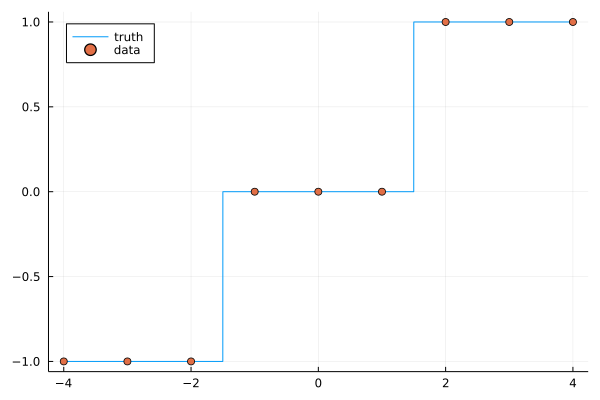

In [106]:
steps(x) = x < -3/2 ? -1 : (x < 3/2 ? 0 : 1)

x = Float64[-4, -1, 2, -3, 0, 3, -2, 1, 4]

Xraw = (x=x,) 
yraw = steps.(x); 

idxsort = sortperm(x) 
xsort = x[idxsort]
ysort = yraw[idxsort]
 
xs = -4:0.001:4
plot(xs, steps.(xs), label="truth")
plot!(x, yraw, seriestype=:scatter, label="data", legend=:topleft)

Now let's pick some models to play with in our stack (we can change them later) 

In [107]:
model1 = linear
model2 = knn

KNNRegressor(
    K = 5,
    algorithm = :kdtree,
    metric = Distances.Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = NearestNeighborModels.Uniform())

and let's pick the adjudicator: 

In [108]:
judge = linear

LinearRegressor(
    fit_intercept = true,
    solver = nothing)

## Defining the training nodes

instantiate inpute and target source nodes, using the play data 

In [109]:
X = source(Xraw) 
y = source(yraw)

Source @559 ⏎ `AbstractVector{Count}`

Now we will make a node that generates the 3 folds (3 vectors of row indices). There are a couple of ways to do this so that our `folds()` function will work on the `node` objects

In [110]:
f = @node folds(X, 3)

Node{Nothing}
  args:
    1:	Source @147
  formula:
    #41(
        Source @147)

try it out to see how it works on the dummy dataset

In [111]:
f()

([1, 2, 3], [4, 5, 6], [7, 8, 9])

Alternatively we can just overload the `folds()` function to work on `nodes`. 

In [112]:
folds(X::AbstractNode, nfolds) = node(χ->folds(χ, nfolds), X)
f = folds(X, 3) 
f()

([1, 2, 3], [4, 5, 6], [7, 8, 9])

We will do the same for `restrict` and `corestrict`. 

In [113]:
MLJ.restrict(X::AbstractNode, f::AbstractNode, i) = node((χ, ϕ) -> restrict(χ, ϕ, i), X, f)

In [114]:
MLJ.corestrict(X::AbstractNode, f::AbstractNode, i) = node((χ, ϕ) -> corestrict(χ, ϕ, i), X, f)

we can now define models to train `model` on each fold-complement

In [115]:
m11 = machine(model1, corestrict(X, f, 1), corestrict(y, f, 1))
m12 = machine(model1, corestrict(X, f, 2), corestrict(y, f, 2))
m13 = machine(model1, corestrict(X, f, 3), corestrict(y, f, 3))

Machine{LinearRegressor,…} trained 0 times; caches data
  args: 
    1:	Node{Nothing}
    2:	Node{Nothing}


define the output for each -out-of-sample prediction of `model1`

In [116]:
y11 = predict(m11, restrict(X, f, 1)); 
y12 = predict(m12, restrict(X, f, 2)); 
y13 = predict(m13, restrict(X, f, 3)); 

splice together each out-of-sample prediction for `model1` to make the final training set. 

In [117]:
y1_oos = vcat(y11, y12, y13); 

Let's check the network so far by fitting `y1_oos`: 

In [120]:
fit!(y1_oos, verbosity=0) 

Node{Nothing}
  args:
    1:	Node{Machine{LinearRegressor,…}}
    2:	Node{Machine{LinearRegressor,…}}
    3:	Node{Machine{LinearRegressor,…}}
  formula:
    vcat(
        predict(
            Machine{LinearRegressor,…}, 
            #45(
                Source @147,
                #43(
                    Source @147))),
        predict(
            Machine{LinearRegressor,…}, 
            #45(
                Source @147,
                #43(
                    Source @147))),
        predict(
            Machine{LinearRegressor,…}, 
            #45(
                Source @147,
                #43(
                    Source @147))))

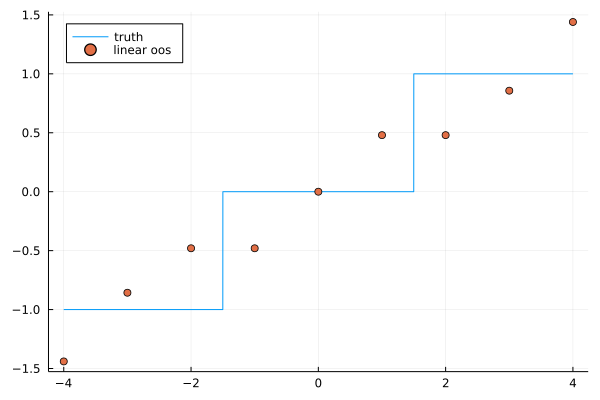

In [122]:
plot(xs, steps.(xs), label="truth")
plot!(x, y1_oos(), seriestype=:scatter, label="linear oos", legend=:topleft)

Now we repeat the procedure for the other model

In [123]:
m21 = machine(model2, corestrict(X, f, 1), corestrict(y, f, 1))
m22 = machine(model2, corestrict(X, f, 2), corestrict(y, f, 2))
m23 = machine(model2, corestrict(X, f, 3), corestrict(y, f, 3))

y21 = predict(m21, restrict(X, f, 1));
y22 = predict(m22, restrict(X, f, 2));
y23 = predict(m23, restrict(X, f, 3));

In [124]:
y2_oos = vcat(y21, y22, y23);

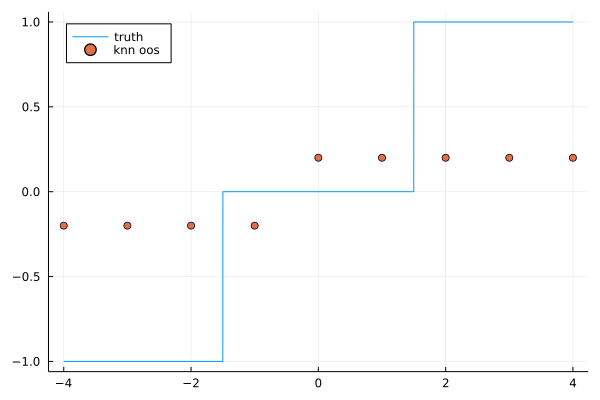

In [125]:
fit!(y2_oos, verbosity=0)

plot(xs, steps.(xs), label="truth")
plot!(x, y2_oos(), seriestype=:scatter, label="knn oos", legend=:topleft)

Now that we have the out-of-sample predictions for each base learner, we can merge them into a table for the adjudicator

In [126]:
X_oos = MLJ.table(hcat(y1_oos, y2_oos))
m_judge = machine(judge, X_oos, y)

Machine{LinearRegressor,…} trained 0 times; caches data
  args: 
    1:	Node{Nothing}
    2:	Source @559 ⏎ `AbstractVector{Count}`


**NOTE:** *we're not done yet*. Now that we can can train thge adjudicator, we need to retrain a version of each base-learner on the full dataset to use for final predictions. 

In [127]:
m1 = machine(model1, X, y) 
m2 = machine(model2, X, y)

Machine{KNNRegressor,…} trained 0 times; caches data
  args: 
    1:	Source @147 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @559 ⏎ `AbstractVector{Count}`


In [128]:
y1 = predict(m1, X); 
y2 = predict(m2, X); 

In [129]:
X_judge = MLJ.table(hcat(y1, y2))
yhat = predict(m_judge, X_judge)

Node{Machine{LinearRegressor,…}}
  args:
    1:	Node{Nothing}
  formula:
    predict(
        Machine{LinearRegressor,…}, 
        table(
            hcat(
                predict(
                    Machine{LinearRegressor,…}, 
                    Source @147),
                predict(
                    Machine{KNNRegressor,…}, 
                    Source @147))))

Now let's fit the final version! 

In [130]:
fit!(yhat, verbosity=1)

┌ Info: Training Machine{LinearRegressor,…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:403
┌ Info: Training Machine{KNNRegressor,…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:403
┌ Info: Not retraining Machine{LinearRegressor,…}. Use `force=true` to force.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:406
┌ Info: Not retraining Machine{LinearRegressor,…}. Use `force=true` to force.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:406
┌ Info: Not retraining Machine{LinearRegressor,…}. Use `force=true` to force.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:406
┌ Info: Not retraining Machine{KNNRegressor,…}. Use `force=true` to force.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:406
┌ Info: Not retraining Machine{KNNRegressor,…}. Use `force=true` to force.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:406
┌ Info: Not retrai

Node{Machine{LinearRegressor,…}}
  args:
    1:	Node{Nothing}
  formula:
    predict(
        Machine{LinearRegressor,…}, 
        table(
            hcat(
                predict(
                    Machine{LinearRegressor,…}, 
                    Source @147),
                predict(
                    Machine{KNNRegressor,…}, 
                    Source @147))))

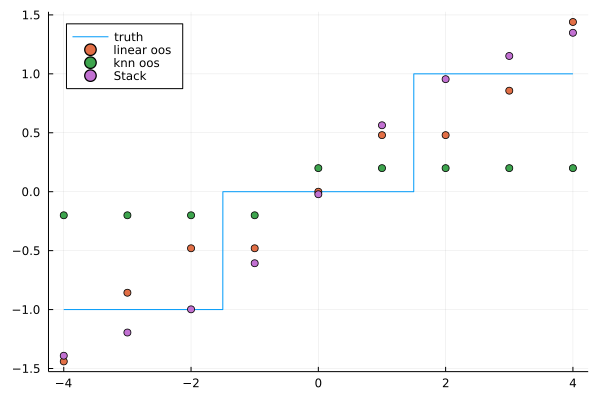

In [131]:
plot(xs, steps.(xs), label="truth")
plot!(x, y1_oos(), seriestype=:scatter, label="linear oos", legend=:topleft)
plot!(x, y2_oos(), seriestype=:scatter, label="knn oos", legend=:topleft)
plot!(x, yhat(), seriestype=:scatter, label="Stack", legend=:topleft)

let's compare the difference between the mean and stack versions

In [132]:
e1 = rms(y1(), y())
e2 = rms(y2(), y())
emean = rms(0.5*y1() + 0.5*y2(), y())
estack = rms(yhat(), y())
@show e1 e2 emean estack;

e1 = 0.2581988897471611
e2 = 0.3771236166328254
emean = 0.2808716591058786
estack = 0.3373908215636325


## export the learning network as a new model type

In [133]:
@from_network machine(Deterministic(), X, y; predict=yhat) begin
    mutable struct MyTwoModelStack
        regressor1=model1
        regressor2=model2
        judge=judge
    end
end

In [134]:
my_two_model_stack = MyTwoModelStack()

MyTwoModelStack(
    regressor1 = LinearRegressor(
            fit_intercept = true,
            solver = nothing),
    regressor2 = KNNRegressor(
            K = 5,
            algorithm = :kdtree,
            metric = Distances.Euclidean(0.0),
            leafsize = 10,
            reorder = true,
            weights = NearestNeighborModels.Uniform()),
    judge = LinearRegressor(
            fit_intercept = true,
            solver = nothing))

## applying `MyTwoModelStack` to some data

Without any hyperparameter optimization, evaluate the performance of a tree boosting algorithm and a support vector machine on a synthetic data set. As adjudicator, we'll use a random forest.

In [143]:
# make synthetic dataset
X, y = make_regression(1000, 20; sparse=0.75, noise=0.1, rng=123);

define stack and compare performance

In [144]:
avg = MyAverageTwo(regressor1=tree_booster, regressor2=svm)

stack = MyTwoModelStack(regressor1=tree_booster, regressor2=svm, judge=forest)

all_models = [tree_booster, svm, forest, avg, stack]

5-element Vector{Deterministic}:
 EvoTreeRegressor{Float64,…}
 SVMRegressor
 RandomForestRegressor
 MyAverageTwo
 MyTwoModelStack

In [145]:
for model in all_models
    print_performance(model, X, y)
end

EvoTreeRegressor{Float64,…} = 1.9201 ± 0.04538
SVMRegressor = 0.93596 ± 0.06682
RandomForestRegressor = 1.7522 ± 0.06762
MyAverageTwo = 1.3103 ± 0.06588
MyTwoModelStack = 0.87045 ± 0.04226


## Tuning a stack 

As a simple proof of concept, let's tune one of the base model hyperparameters

In [146]:
r = range(stack, :(regressor2.C), lower=0.01, upper=10, scale=:log)

tuned_stack = TunedModel(model=stack, 
    ranges = r, 
    tuning = Grid(shuffle=false), 
    measure= rms,
    resampling=Holdout()
)

DeterministicTunedModel(
    model = MyTwoModelStack(
            regressor1 = EvoTreeRegressor{Float64,…},
            regressor2 = SVMRegressor,
            judge = RandomForestRegressor),
    tuning = Grid(
            goal = nothing,
            resolution = 10,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    resampling = Holdout(
            fraction_train = 0.7,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = RootMeanSquaredError(),
    weights = nothing,
    operation = nothing,
    range = NumericRange(0.01 ≤ regressor2.C ≤ 10.0; origin=5.005, unit=4.995) on log scale,
    selection_heuristic = MLJTuning.NaiveSelection(nothing),
    train_best = true,
    repeats = 1,
    n = nothing,
    acceleration = CPU1{Nothing}(nothing),
    acceleration_resampling = CPU1{Nothing}(nothing),
    check_measure = true,
    cache = true)

In [147]:
mach = fit!(machine(tuned_stack,  X, y), verbosity=0)
best_stack = fitted_params(mach).best_model
best_stack.regressor2.C

10.000000000000002

In [148]:
print_performance(best_stack, X, y)

MyTwoModelStack = 0.85022 ± 0.04076


In [152]:
stack.regressor1

EvoTreeRegressor(
    loss = EvoTrees.Linear(),
    nrounds = 10,
    λ = 0.0,
    γ = 0.0,
    η = 0.1,
    max_depth = 5,
    min_weight = 1.0,
    rowsample = 1.0,
    colsample = 1.0,
    nbins = 64,
    α = 0.5,
    metric = :mse,
    rng = Random.MersenneTwister(123, (0, 286572, 285570, 830)),
    device = "cpu")

In [153]:
stack.regressor2

SVMRegressor(
    kernel = "rbf",
    degree = 3,
    gamma = "auto",
    coef0 = 0.0,
    tol = 0.001,
    C = 1.0,
    epsilon = 0.1,
    shrinking = true,
    cache_size = 200,
    max_iter = -1)

# Stacking - The Easy Way

MLJ now has a canned model for doing Stacking. Let's repreat the previous analysis using the cleaner syntax 

In [155]:
stack = Stack(;metalearner=forest,
    resampling=CV(nfolds=3),
    regressor1=tree_booster,
    regressor2=svm
)

DeterministicStack(
    resampling = CV(
            nfolds = 3,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    metalearner = RandomForestRegressor(
            max_depth = -1,
            min_samples_leaf = 1,
            min_samples_split = 2,
            min_purity_increase = 0.0,
            n_subfeatures = -1,
            n_trees = 10,
            sampling_fraction = 0.7,
            pdf_smoothing = 0.0,
            rng = Random._GLOBAL_RNG()),
    regressor1 = EvoTreeRegressor(
            loss = EvoTrees.Linear(),
            nrounds = 10,
            λ = 0.0,
            γ = 0.0,
            η = 0.1,
            max_depth = 5,
            min_weight = 1.0,
            rowsample = 1.0,
            colsample = 1.0,
            nbins = 64,
            α = 0.5,
            metric = :mse,
            rng = Random.MersenneTwister(123, (0, 286572, 285570, 830)),
            device = "cpu"),
    regressor2 = SVMRegressor(
            kernel = "rbf",
         

In [159]:
mach = machine(stack, X, y)
fit!(mach, verbosity=0)

Machine{DeterministicStack{,…},…} trained 1 time; caches data
  args: 
    1:	Source @734 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @070 ⏎ `AbstractVector{Continuous}`


In [161]:
rmse(predict(mach, X), y)

0.7204097503965626

In [163]:
stack.metalearner

RandomForestRegressor(
    max_depth = -1,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = -1,
    n_trees = 10,
    sampling_fraction = 0.7,
    pdf_smoothing = 0.0,
    rng = Random._GLOBAL_RNG())

In [164]:
stack.regressor1

EvoTreeRegressor(
    loss = EvoTrees.Linear(),
    nrounds = 10,
    λ = 0.0,
    γ = 0.0,
    η = 0.1,
    max_depth = 5,
    min_weight = 1.0,
    rowsample = 1.0,
    colsample = 1.0,
    nbins = 64,
    α = 0.5,
    metric = :mse,
    rng = Random.MersenneTwister(123, (0, 409818, 408816, 784)),
    device = "cpu")

In [165]:
stack.regressor2

SVMRegressor(
    kernel = "rbf",
    degree = 3,
    gamma = "auto",
    coef0 = 0.0,
    tol = 0.001,
    C = 1.0,
    epsilon = 0.1,
    shrinking = true,
    cache_size = 200,
    max_iter = -1)